In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

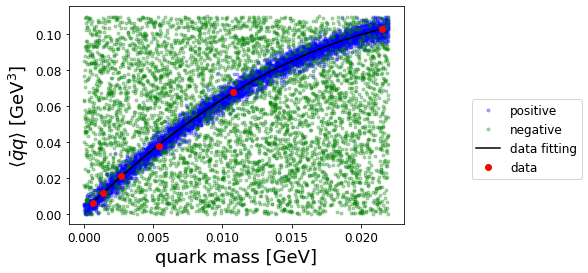

In [9]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=5000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [10]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [11]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
[ 9.611118    5.8046985   2.031419   -0.3643227   0.34502104 -0.37659597
  1.8433071   6.6515636   9.239104    1.555776    1.804459    3.2066581
  5.2900405   4.4768734   4.498876  ]


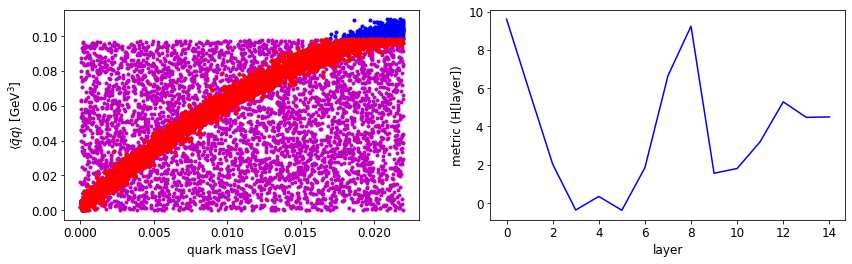

In [26]:
d = 4
m2 = -3 # mass^2
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
Test = MetricNet(Number_of_layers=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta,d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters()) 
Test.train()

print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [7]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

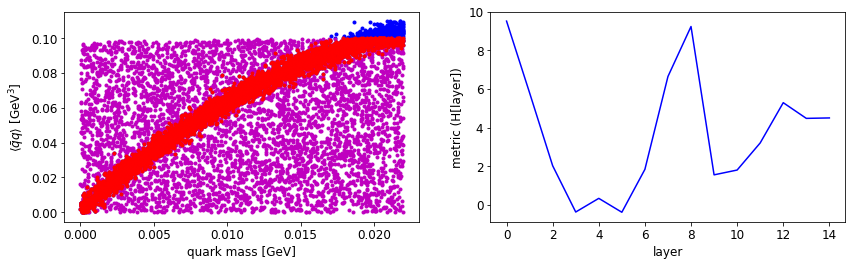

training epoch: 0,   loss: 0.5642015337944031
lambda: 0.17816616594791412,   AdS radius: 0.7996252775192261[1/GeV]
[ 9.511468    5.795464    2.0235534  -0.37165403  0.3352542  -0.3836906
  1.8366265   6.6444583   9.232013    1.552698    1.8012089   3.20424
  5.2884693   4.4762053   4.49895   ]


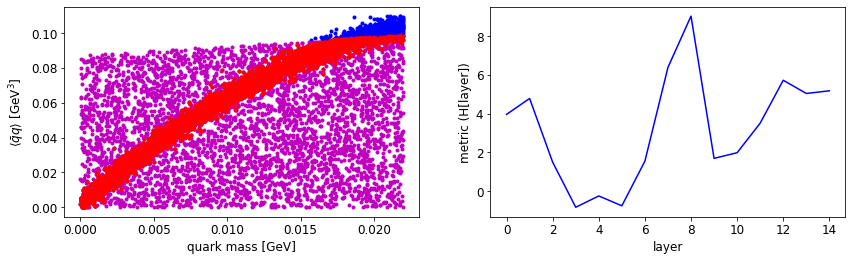

training epoch: 100,   loss: 0.2375584989786148
lambda: -2.0204334259033203,   AdS radius: 1.0846143960952759[1/GeV]
[ 3.9584286   4.7783923   1.4902724  -0.83522457 -0.25295466 -0.7601246
  1.5419568   6.382121    9.0293      1.6875995   1.9794197   3.5058472
  5.719174    5.036929    5.17501   ]


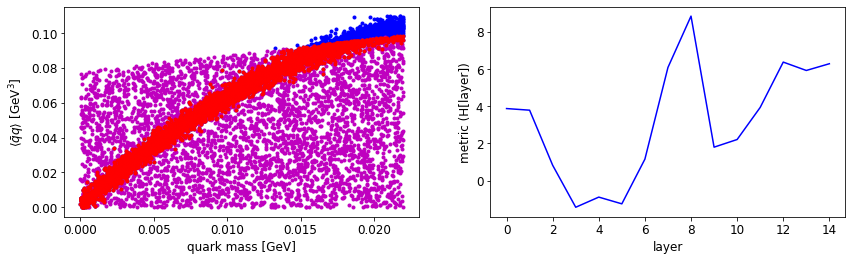

training epoch: 200,   loss: 0.2220723032951355
lambda: -4.746035575866699,   AdS radius: 1.3892362117767334[1/GeV]
[ 3.8751142   3.7877617   0.82592684 -1.4315891  -0.8863687  -1.2484013
  1.1547949   6.0857406   8.846295    1.7994066   2.2106886   3.9357083
  6.3737392   5.923787    6.2859387 ]


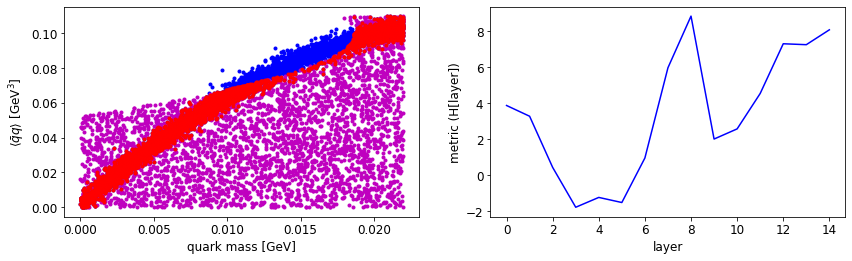

training epoch: 300,   loss: 0.18883678317070007
lambda: -5.6669087409973145,   AdS radius: 1.827746868133545[1/GeV]
[ 3.8786085   3.2806783   0.43483546 -1.7810034  -1.2344644  -1.518273
  0.9594801   5.978108    8.850014    2.0125031   2.5771687   4.5468173
  7.312394    7.260733    8.08806   ]


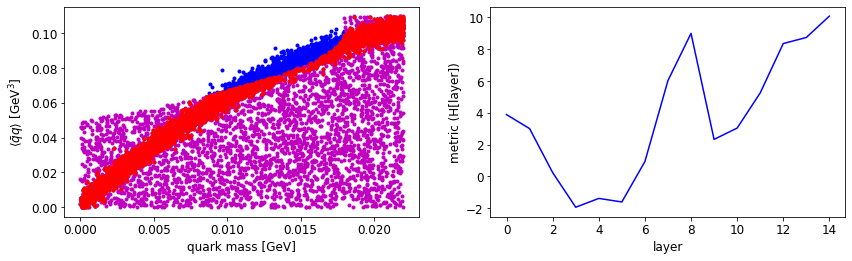

training epoch: 400,   loss: 0.17769791185855865
lambda: -5.139654159545898,   AdS radius: 1.8133411407470703[1/GeV]
[ 3.8843803   3.0042102   0.24033491 -1.9360654  -1.3806788  -1.6042529
  0.93241346  6.0223107   8.988157    2.328232    3.037006    5.2445116
  8.348776    8.730548   10.073256  ]


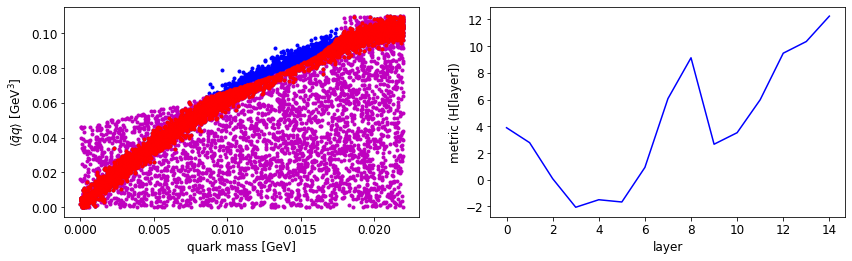

training epoch: 500,   loss: 0.16637583076953888
lambda: -4.499919891357422,   AdS radius: 1.7981075048446655[1/GeV]
[ 3.887301    2.7676146   0.06935286 -2.0720947  -1.5093007  -1.6785332
  0.91275877  6.0707173   9.129507    2.6513617   3.5150418   5.9854035
  9.473565   10.348568   12.252292  ]


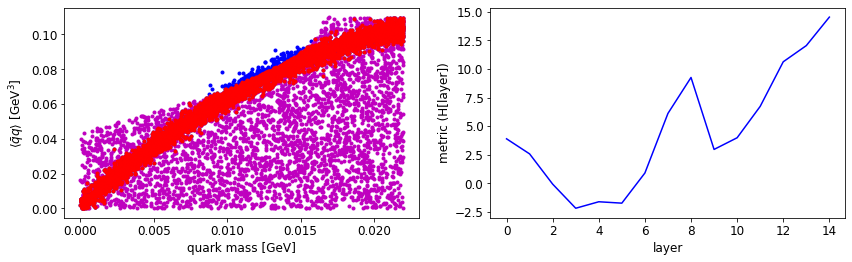

training epoch: 600,   loss: 0.15536701679229736
lambda: -3.7632839679718018,   AdS radius: 1.7886805534362793[1/GeV]
[ 3.888004    2.5676897  -0.07924402 -2.1909785  -1.6229799  -1.7450582
  0.89427036  6.113264    9.258755    2.9591079   3.9804788   6.727707
 10.632829   12.048805   14.543223  ]


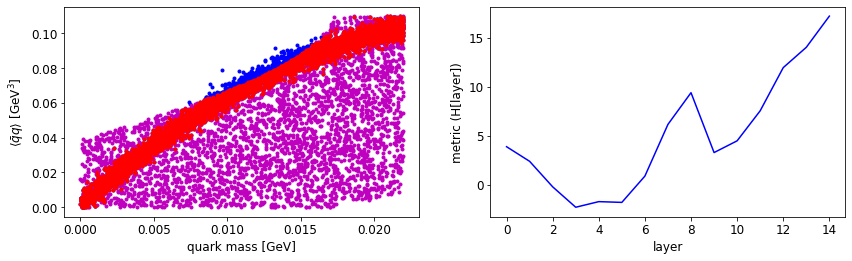

training epoch: 700,   loss: 0.1443341225385666
lambda: -2.8007616996765137,   AdS radius: 1.804572582244873[1/GeV]
[ 3.8840437   2.3919718  -0.21233705 -2.2969036  -1.7236935  -1.8019121
  0.88375825  6.163796    9.398823    3.2855122   4.483845    7.5514026
 11.957028   14.030863   17.215265  ]


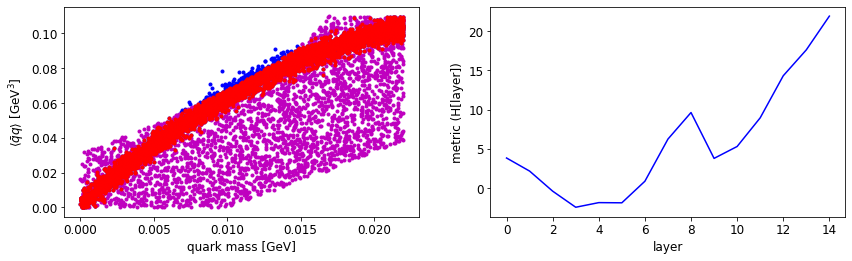

training epoch: 800,   loss: 0.10578350722789764
lambda: -0.6414113640785217,   AdS radius: 2.028381586074829[1/GeV]
[ 3.8154826   2.1451685  -0.41687477 -2.4688127  -1.8785416  -1.9029725
  0.8507983   6.23268     9.618836    3.7670774   5.2858744   8.941528
 14.3113785  17.617422   21.925539  ]


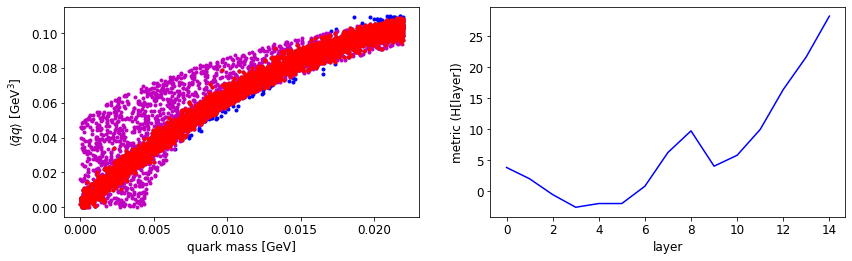

training epoch: 900,   loss: 0.027767974883317947
lambda: 0.05155077204108238,   AdS radius: 3.1378984451293945[1/GeV]
[ 3.7924666   1.9697602  -0.57740885 -2.616426   -2.0192802  -2.0174143
  0.7724889   6.2123675   9.690337    4.0054393   5.75994     9.917001
 16.350403   21.62858    28.186596  ]


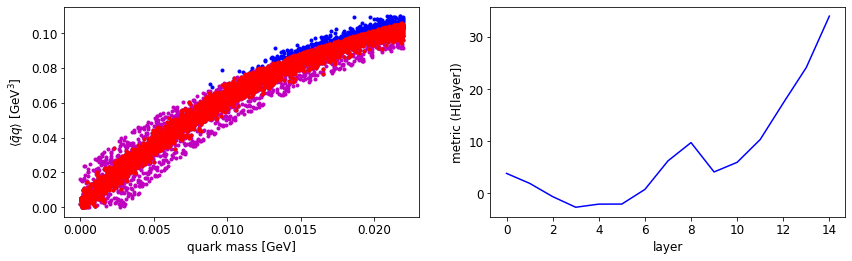

training epoch: 1000,   loss: 0.018538471311330795
lambda: 0.011589949019253254,   AdS radius: 3.5345606803894043[1/GeV]
[ 3.8416257  1.9418769 -0.5992534 -2.6333447 -2.0362625 -2.0246897
  0.7761451  6.231908   9.736982   4.119594   5.958137  10.321246
 17.29564   24.10553   33.931934 ]


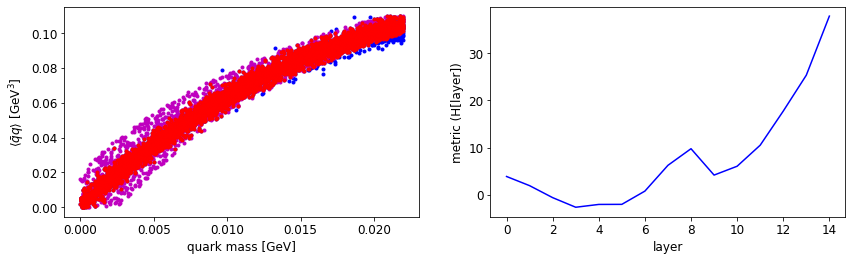

training epoch: 1100,   loss: 0.012950190342962742
lambda: 0.008121076039969921,   AdS radius: 3.6092066764831543[1/GeV]
[ 3.866429    1.9241269  -0.6134353  -2.644779   -2.048876   -2.032333
  0.77282923  6.2335224   9.747816    4.164963    6.0373163  10.489872
 17.709305   25.314219   37.82286   ]


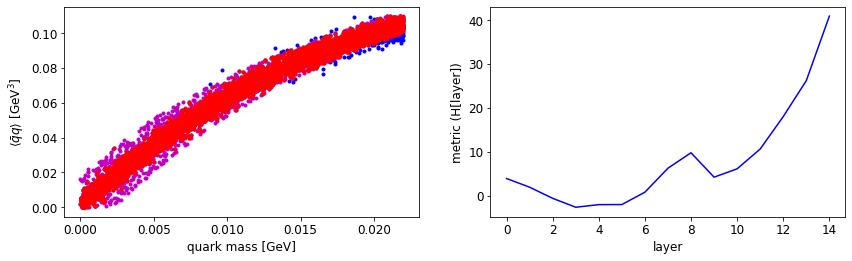

training epoch: 1200,   loss: 0.011412525549530983
lambda: 0.008030741475522518,   AdS radius: 3.568679094314575[1/GeV]
[ 3.8879526   1.9137666  -0.62081575 -2.6498828  -2.055547   -2.03508
  0.7728147   6.235703    9.754853    4.198993    6.0927052  10.605662
 17.99342    26.170832   40.86022   ]


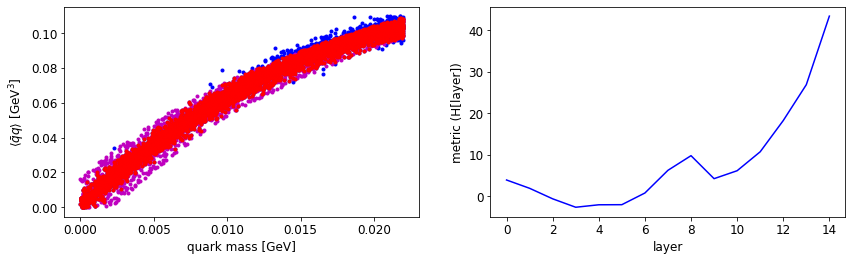

training epoch: 1300,   loss: 0.010505313985049725
lambda: 0.010768542066216469,   AdS radius: 3.4924888610839844[1/GeV]
[ 3.904649    1.9055436  -0.62642336 -2.6534941  -2.0609388  -2.037068
  0.77275234  6.2364826   9.758277    4.225659    6.1345468  10.693255
 18.20966    26.839758   43.345646  ]


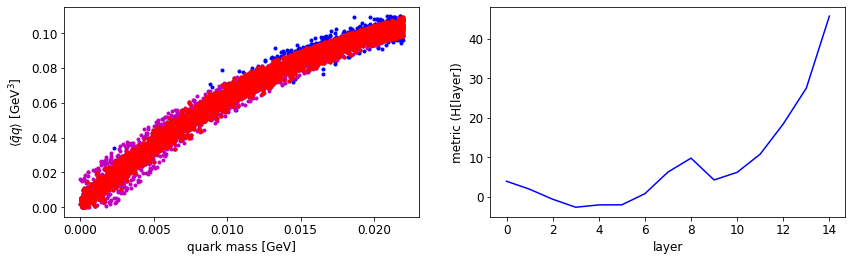

training epoch: 1400,   loss: 0.011118578724563122
lambda: 0.012697231024503708,   AdS radius: 3.41477370262146[1/GeV]
[ 3.9184222  1.8980553 -0.6313826 -2.6564984 -2.0659978 -2.0388153
  0.7726004  6.236419   9.759758   4.2499638  6.171548  10.770846
 18.402466  27.450008  45.669205 ]


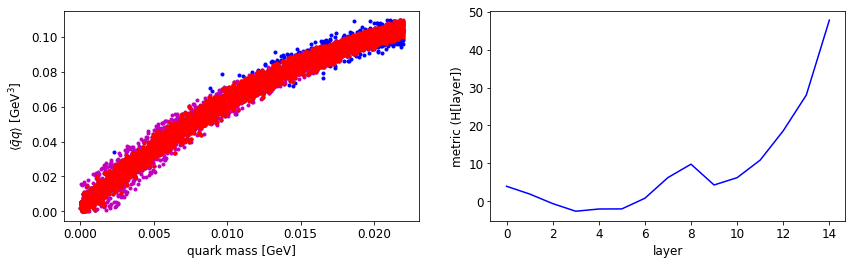

training epoch: 1500,   loss: 0.010676895268261433
lambda: 0.013525208458304405,   AdS radius: 3.3558156490325928[1/GeV]
[ 3.9300926  1.8917717 -0.6352621 -2.658517  -2.0703332 -2.0399168
  0.7727884  6.236034   9.759955   4.2726164  6.204661  10.84002
 18.574547  28.003336  47.787563 ]


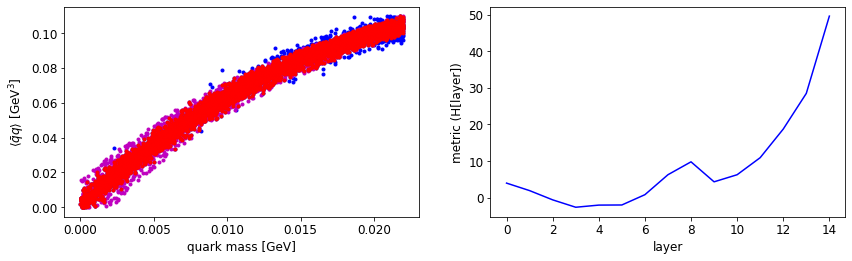

training epoch: 1600,   loss: 0.009790901094675064
lambda: 0.016305403783917427,   AdS radius: 3.2772183418273926[1/GeV]
[ 3.9396822  1.8864771 -0.638207  -2.6596315 -2.0739894 -2.0404189
  0.7732564  6.235213   9.758608   4.2931333  6.233034  10.89871
 18.720207  28.479727  49.609814 ]


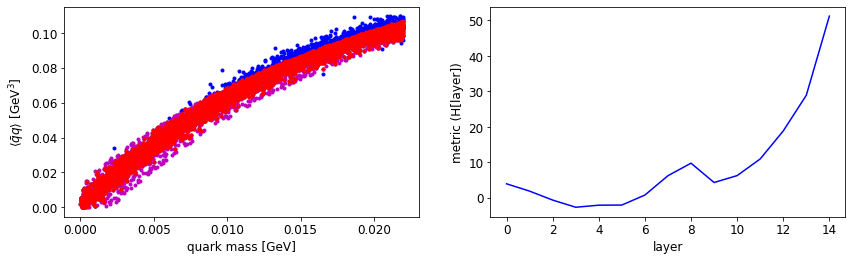

training epoch: 1700,   loss: 0.010246669873595238
lambda: 0.02037346549332142,   AdS radius: 3.1977198123931885[1/GeV]
[ 3.9483764   1.883013   -0.63937396 -2.6589892  -2.076061   -2.0394049
  0.7750121   6.23518     9.757304    4.313383    6.25932    10.951471
 18.849133   28.905355   51.217567  ]


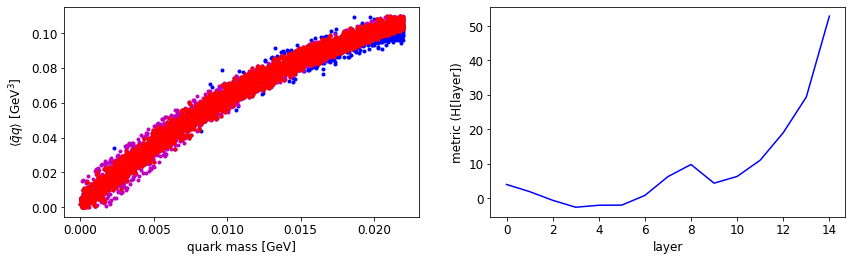

training epoch: 1800,   loss: 0.009883261285722256
lambda: 0.020250681787729263,   AdS radius: 3.138732671737671[1/GeV]
[ 3.9534144   1.8775766  -0.6424731  -2.6602151  -2.0803266  -2.040406
  0.77469486  6.232689    9.753118    4.332229    6.283958   11.003029
 18.978662   29.341925   52.835377  ]


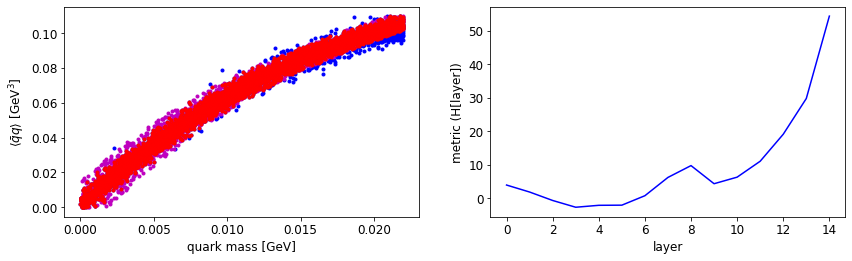

training epoch: 1900,   loss: 0.011489074677228928
lambda: 0.026085253804922104,   AdS radius: 3.0762851238250732[1/GeV]
[ 3.9575286  1.8729405 -0.6447566 -2.660604  -2.083962  -2.0407326
  0.7748913  6.2302723  9.748313   4.3508615  6.307106  11.050836
 19.097717  29.748087  54.300888 ]


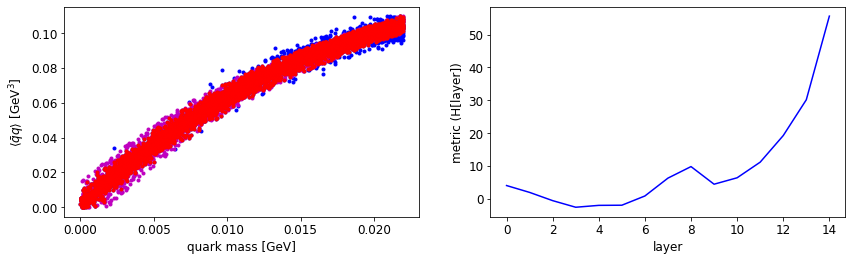

training epoch: 2000,   loss: 0.00961458683013916
lambda: 0.03083978220820427,   AdS radius: 3.0180587768554688[1/GeV]
[ 3.9614801   1.8697877  -0.6455959  -2.6595466  -2.0862858  -2.0397682
  0.77627707  6.2287807   9.744021    4.3699536   6.329882   11.096403
 19.209448   30.132122   55.65494   ]


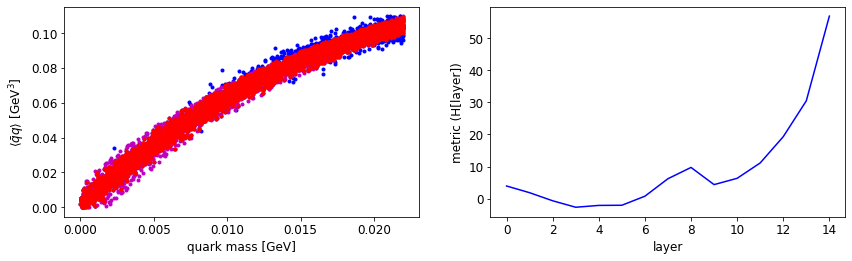

training epoch: 2100,   loss: 0.00935615785419941
lambda: 0.03516542539000511,   AdS radius: 2.962174654006958[1/GeV]
[ 3.9645183  1.8670065 -0.6461074 -2.658196  -2.0883713 -2.0385845
  0.7777394  6.227096   9.739241   4.3883505  6.3510447 11.13852
 19.312515  30.488766  56.86748  ]


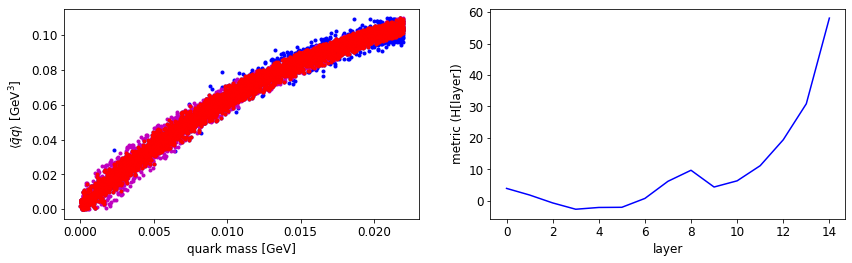

training epoch: 2200,   loss: 0.008993205614387989
lambda: 0.040450140833854675,   AdS radius: 2.912228584289551[1/GeV]
[ 3.9660108  1.8633102 -0.6474392 -2.6575627 -2.0914664 -2.0382311
  0.7783642  6.2242613  9.732964   4.4068365  6.372168  11.181426
 19.41894   30.861504  58.084785 ]


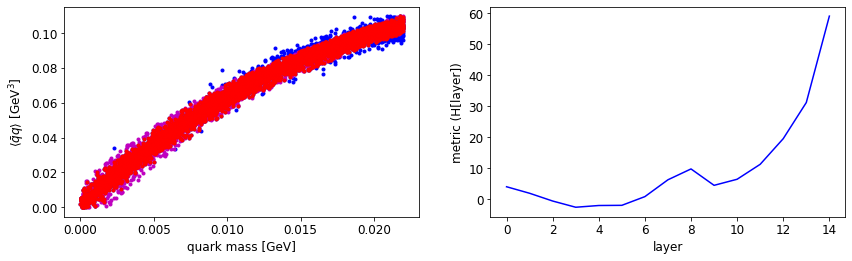

training epoch: 2300,   loss: 0.00929985661059618
lambda: 0.046471379697322845,   AdS radius: 2.8609020709991455[1/GeV]
[ 3.9677405  1.860674  -0.6477724 -2.6559732 -2.093672  -2.037093
  0.7796336  6.2217603  9.726536   4.424567   6.391252  11.21912
 19.511232  31.188591  59.115868 ]


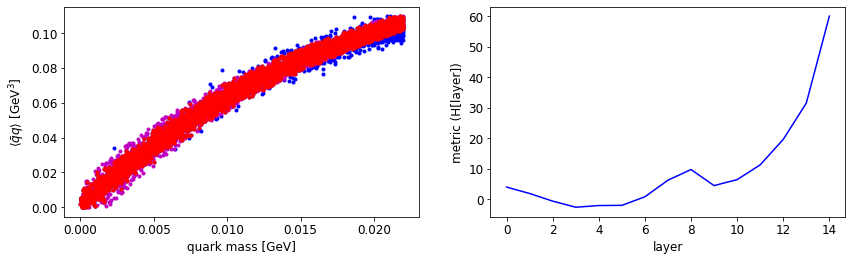

training epoch: 2400,   loss: 0.009156833402812481
lambda: 0.05270273983478546,   AdS radius: 2.8033807277679443[1/GeV]
[ 3.9687164  1.8576577 -0.6483816 -2.6545558 -2.0963671 -2.036238
  0.780493   6.2183666  9.71863    4.4420385  6.409245  11.254764
 19.598534  31.502264  60.039356 ]


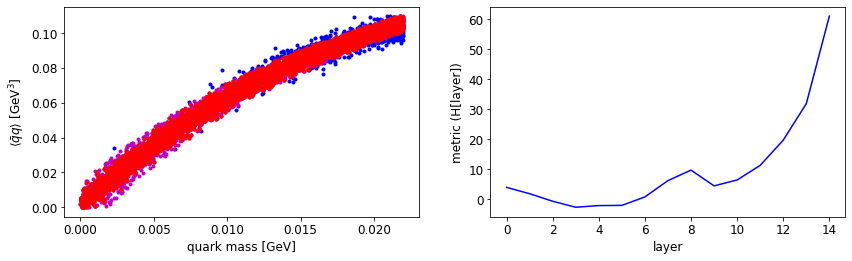

training epoch: 2500,   loss: 0.009361667558550835
lambda: 0.05850560590624809,   AdS radius: 2.7624073028564453[1/GeV]
[ 3.970008    1.8554012  -0.6482302  -2.6523557  -2.09843    -2.034654
  0.78206575  6.2155523   9.711111    4.4609246   6.4287744  11.292887
 19.691307   31.833277   60.98353   ]


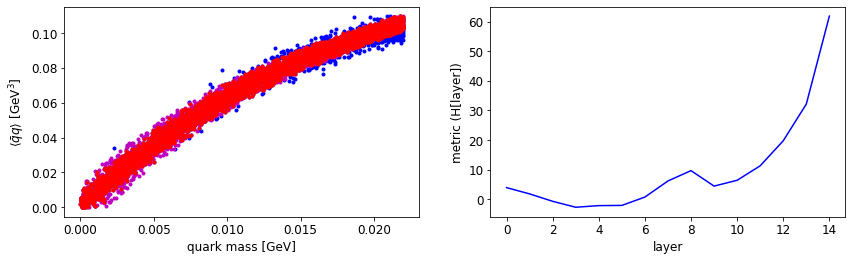

training epoch: 2600,   loss: 0.009432399645447731
lambda: 0.06846798211336136,   AdS radius: 2.7201151847839355[1/GeV]
[ 3.9702146  1.8523499 -0.6488344 -2.6508698 -2.1013935 -2.0339148
  0.7827171  6.211449   9.701947   4.4786987  6.4464755 11.328011
 19.777792  32.148777  61.834717 ]


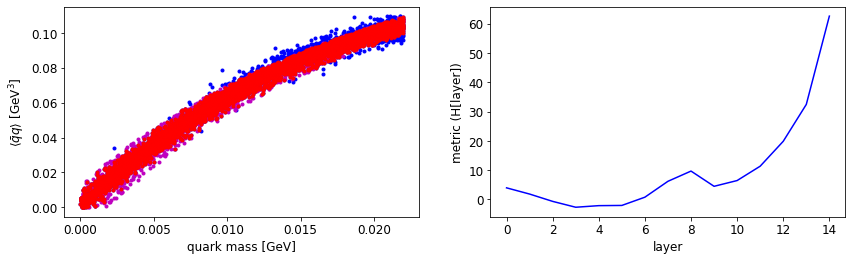

training epoch: 2700,   loss: 0.009109108708798885
lambda: 0.07594141364097595,   AdS radius: 2.6781039237976074[1/GeV]
[ 3.9717844   1.8510234  -0.647738   -2.6476805  -2.102692   -2.0315351
  0.78492767  6.208739    9.694008    4.4975667   6.4647517  11.362436
 19.860008   32.444294   62.57711   ]


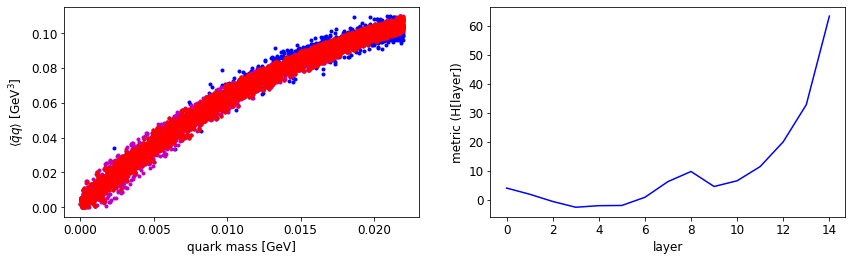

training epoch: 2800,   loss: 0.009378345683217049
lambda: 0.08516230434179306,   AdS radius: 2.63908314704895[1/GeV]
[ 3.9718456   1.8483222  -0.6479413  -2.6457348  -2.1054988  -2.0305147
  0.78571653  6.204251    9.683818    4.5154257   6.481559   11.395286
 19.940554   32.741337   63.292683  ]


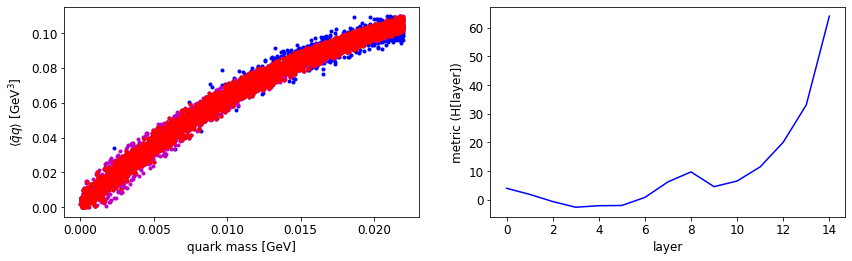

training epoch: 2900,   loss: 0.008944167755544186
lambda: 0.09484732896089554,   AdS radius: 2.6024303436279297[1/GeV]
[ 3.9719532  1.845767  -0.6479704 -2.643579  -2.1082187 -2.0293417
  0.7866114  6.1996236  9.673224   4.5335793  6.498379  11.427864
 20.02028   33.035076  63.970314 ]


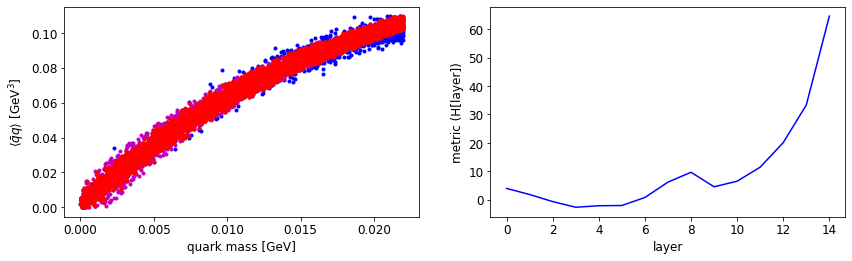

training epoch: 3000,   loss: 0.031040124595165253
lambda: 0.10537610203027725,   AdS radius: 2.5701942443847656[1/GeV]
[ 3.970458    1.8429543  -0.6480537  -2.6412764  -2.1114695  -2.0282693
  0.78724664  6.193871    9.660568    4.552686    6.515275   11.46057
 20.100307   33.331844   64.59109   ]


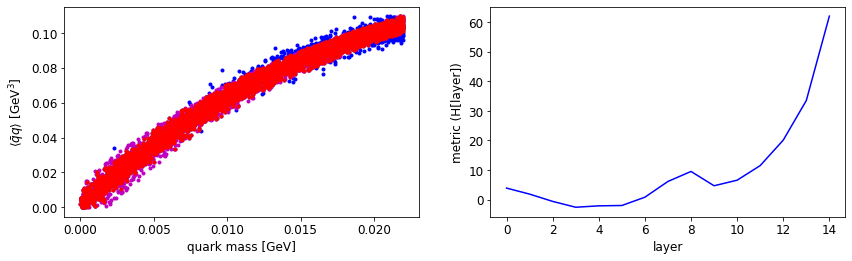

training epoch: 3100,   loss: 0.030025066807866096
lambda: 0.10872485488653183,   AdS radius: 2.555323362350464[1/GeV]
[ 3.8790028   1.8443935  -0.62256825 -2.5972037  -2.1239905  -2.0052578
  0.7979975   6.129176    9.509293    4.671116    6.550713   11.489806
 20.102715   33.50052    62.053177  ]


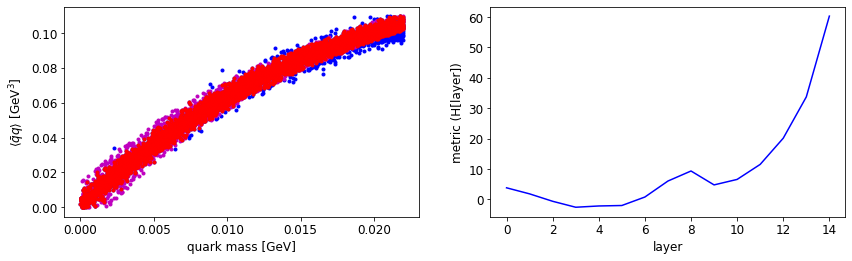

training epoch: 3200,   loss: 0.029767856001853943
lambda: 0.11528865993022919,   AdS radius: 2.552147626876831[1/GeV]
[ 3.8284347  1.8360013 -0.6040516 -2.5602787 -2.1425939 -1.9891986
  0.8017425  6.0572877  9.355957   4.7842393  6.588239  11.52671
 20.138638  33.711906  60.27287  ]


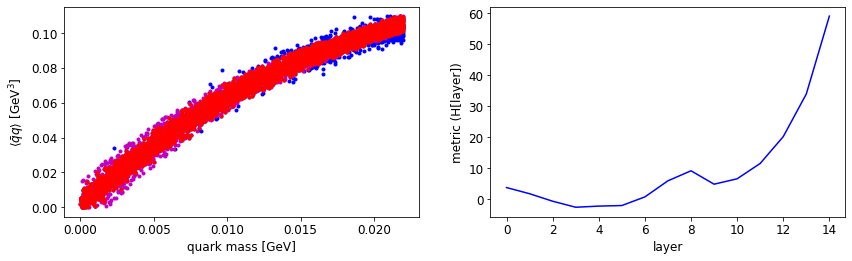

training epoch: 3300,   loss: 0.02870158851146698
lambda: 0.11550752818584442,   AdS radius: 2.5547921657562256[1/GeV]
[ 3.8030257  1.8263804 -0.5864809 -2.5247893 -2.1606221 -1.9741291
  0.8044932  5.985363   9.208517   4.894651   6.6304746 11.570761
 20.196121  33.92588   58.99049  ]


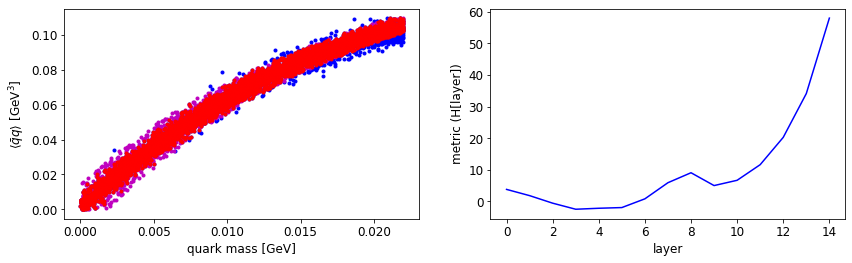

training epoch: 3400,   loss: 0.028434304520487785
lambda: 0.11118071526288986,   AdS radius: 2.5598535537719727[1/GeV]
[ 3.788958    1.8151233  -0.57113844 -2.4918923  -2.1796796  -1.9614357
  0.8046708   5.9112124   9.063707    5.000839    6.674614   11.617635
 20.264624   34.12357    58.009796  ]


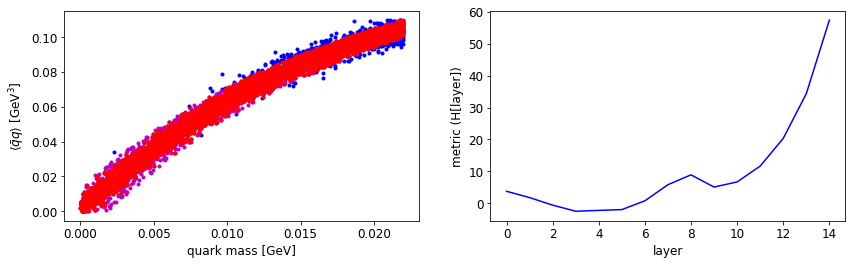

training epoch: 3500,   loss: 0.02917514741420746
lambda: 0.10844884812831879,   AdS radius: 2.5615780353546143[1/GeV]
[ 3.7826896  1.8060186 -0.5561056 -2.4606202 -2.1959112 -1.9489411
  0.805217   5.842195   8.932418   5.1000094  6.721133  11.668074
 20.343319  34.311764  57.35166  ]


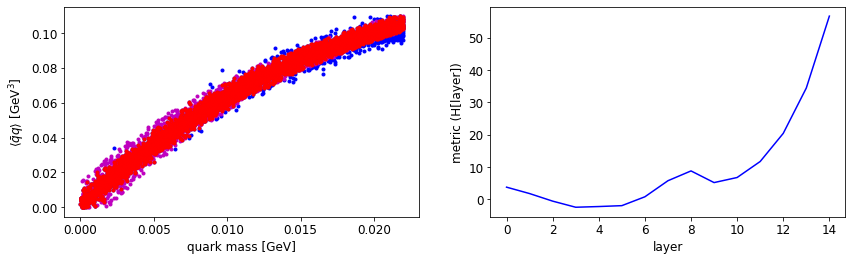

training epoch: 3600,   loss: 0.027746688574552536
lambda: 0.11184847354888916,   AdS radius: 2.5687038898468018[1/GeV]
[ 3.777069   1.795045  -0.5438902 -2.4324062 -2.2144837 -1.9397647
  0.8019024  5.768553   8.799196   5.193284   6.7650385 11.712858
 20.410074  34.432037  56.66774  ]


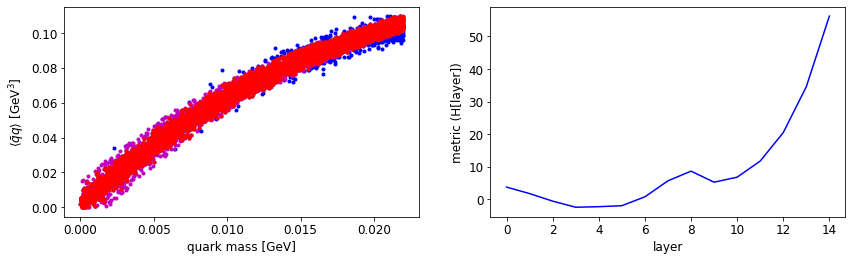

training epoch: 3700,   loss: 0.02715493179857731
lambda: 0.10710612684488297,   AdS radius: 2.574934244155884[1/GeV]
[ 3.7749147  1.7869428 -0.5303099 -2.4034286 -2.2301657 -1.9292697
  0.7999225  5.697941   8.673816   5.285243   6.8140836 11.764594
 20.490963  34.570232  56.23316  ]


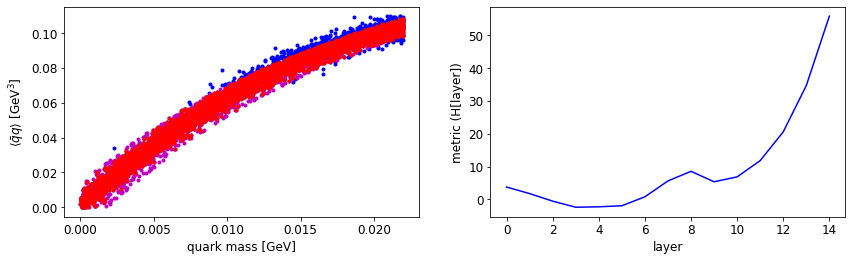

training epoch: 3800,   loss: 0.026698686182498932
lambda: 0.1073479875922203,   AdS radius: 2.5787928104400635[1/GeV]
[ 3.7746584  1.7811018 -0.5164604 -2.3752282 -2.243606  -1.9187899
  0.7980623  5.630381   8.556623   5.3705816  6.861609  11.811839
 20.558506  34.64639   55.770096 ]


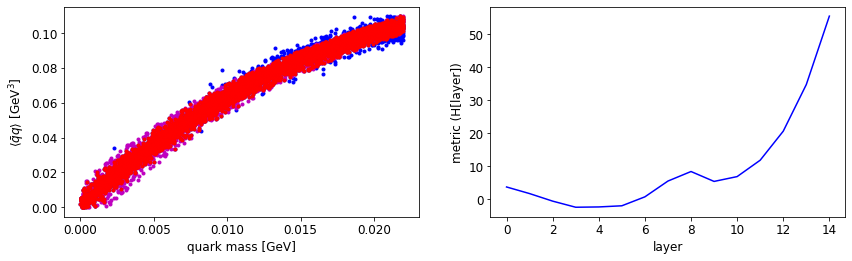

training epoch: 3900,   loss: 0.02678842470049858
lambda: 0.10407465696334839,   AdS radius: 2.576805830001831[1/GeV]
[ 3.7730565   1.7744097  -0.50467646 -2.3496392  -2.2579808  -1.910575
  0.79380435  5.56163     8.441753    5.4506354   6.9085345  11.858163
 20.62467    34.70892    55.38452   ]


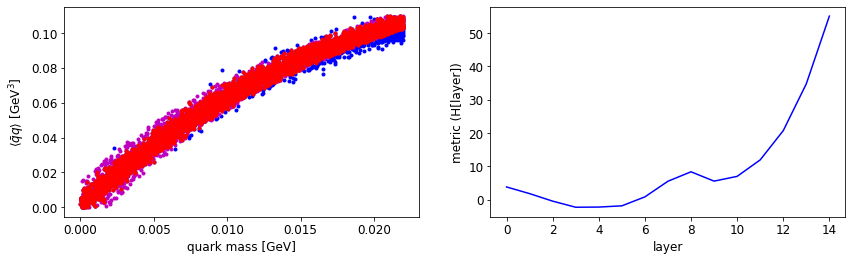

training epoch: 4000,   loss: 0.028182853013277054
lambda: 0.10143160820007324,   AdS radius: 2.5815012454986572[1/GeV]
[ 3.7708614   1.7677897  -0.49422035 -2.3261406  -2.2722547  -1.9038618
  0.7881699   5.49375     8.331794    5.525902    6.9560323  11.906309
 20.695839   34.78459    55.137894  ]


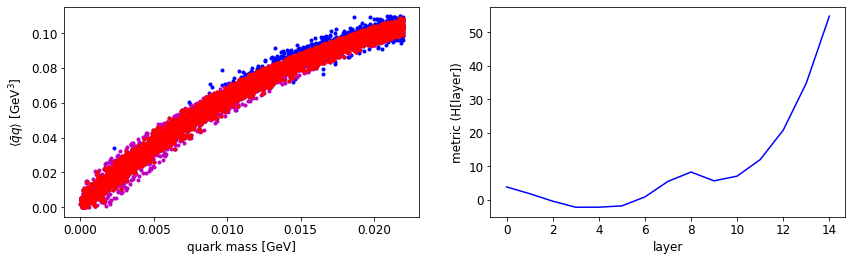

training epoch: 4100,   loss: 0.02608673833310604
lambda: 0.10454678535461426,   AdS radius: 2.5843405723571777[1/GeV]
[ 3.771866    1.7651557  -0.48114282 -2.3008285  -2.2824543  -1.8947316
  0.7850445   5.4307756   8.230329    5.5988116   7.0052342  11.954637
 20.76137    34.830914   54.876328  ]


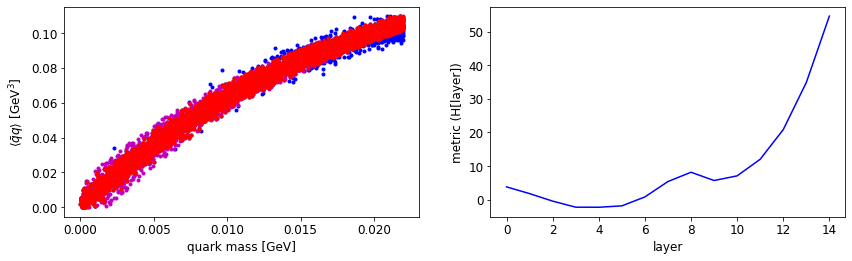

training epoch: 4200,   loss: 0.026473520323634148
lambda: 0.0996997058391571,   AdS radius: 2.578958511352539[1/GeV]
[ 3.770753    1.7611032  -0.47037596 -2.2783332  -2.2940319  -1.888164
  0.77923167  5.366196    8.129978    5.666335    7.0526276  12.000375
 20.821383   34.860825   54.635307  ]


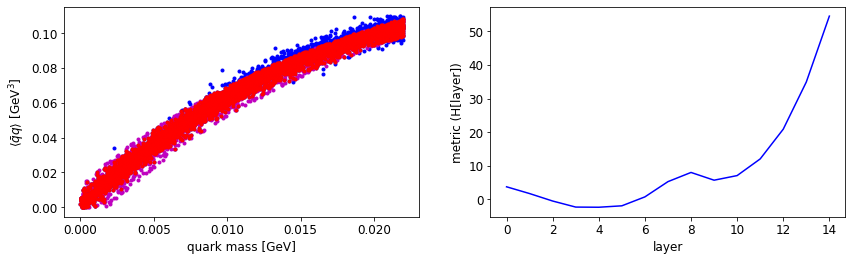

training epoch: 4300,   loss: 0.025614101439714432
lambda: 0.10366833955049515,   AdS radius: 2.5838212966918945[1/GeV]
[ 3.7714126   1.7593141  -0.45814428 -2.2548518  -2.3034248  -1.8804009
  0.77446914  5.303645    8.0340395   5.7331676   7.10321    12.05026
 20.887232   34.904667   54.47839   ]


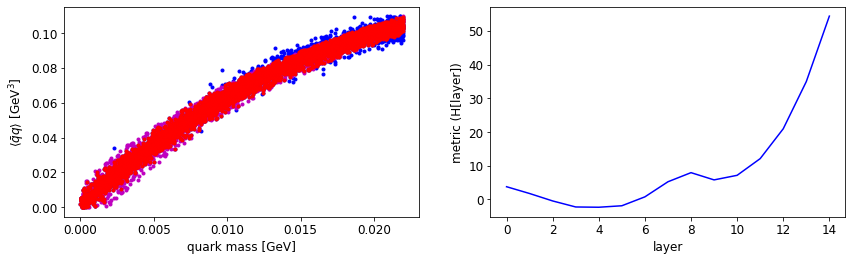

training epoch: 4400,   loss: 0.025241151452064514
lambda: 0.10210012644529343,   AdS radius: 2.5863609313964844[1/GeV]
[ 3.7702303  1.7563175 -0.4480885 -2.234201  -2.3138857 -1.8750114
  0.7674025  5.240772   7.9405837  5.794289   7.151636  12.09784
 20.948818  34.941216  54.345074 ]


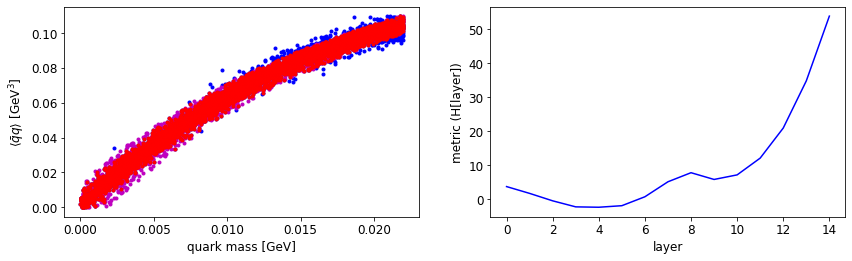

training epoch: 4500,   loss: 0.18648459017276764
lambda: 0.10058853775262833,   AdS radius: 2.582855463027954[1/GeV]
[ 3.759158    1.7565881  -0.43439233 -2.2095802  -2.321929   -1.8670536
  0.7613447   5.174512    7.842543    5.8575144   7.201982   12.140589
 20.984684   34.870483   53.925003  ]


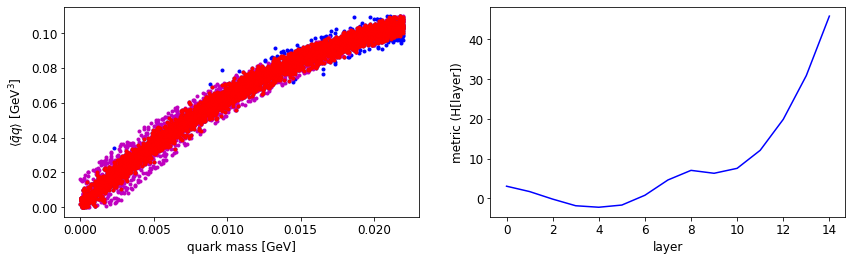

training epoch: 4600,   loss: 0.14365671575069427
lambda: 0.07792558521032333,   AdS radius: 2.6987223625183105[1/GeV]
[ 3.0414765   1.6891778  -0.20786163 -1.8791546  -2.2557943  -1.7046006
  0.7614416   4.6140027   7.031517    6.296067    7.5417843  12.078391
 19.874851   30.890285   45.86974   ]


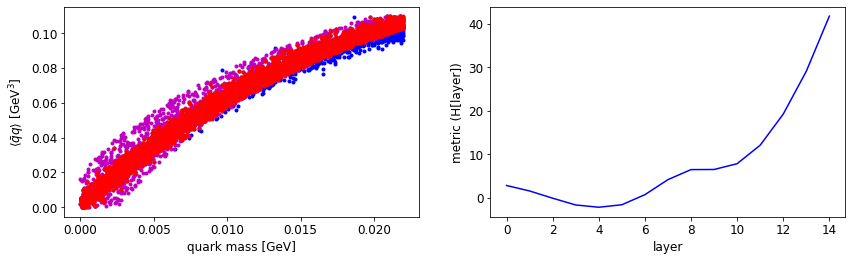

training epoch: 4700,   loss: 0.12893737852573395
lambda: 0.046451032161712646,   AdS radius: 2.9094889163970947[1/GeV]
[ 2.8175597   1.5591607  -0.10221875 -1.6618288  -2.1828794  -1.6096953
  0.7071024   4.166466    6.4733334   6.49967     7.829821   12.085234
 19.234562   29.089258   41.7662    ]


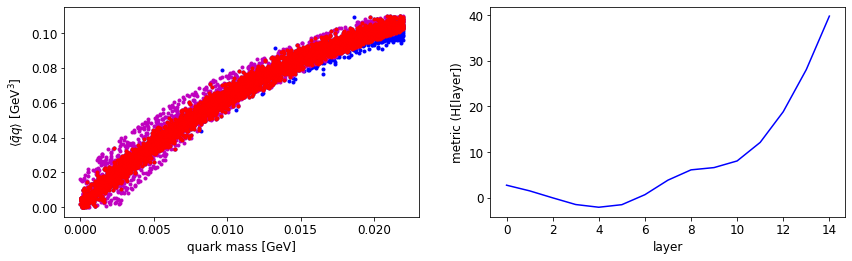

training epoch: 4800,   loss: 0.12102851271629333
lambda: 0.024072088301181793,   AdS radius: 3.1265811920166016[1/GeV]
[ 2.725432    1.485191   -0.04582258 -1.5125034  -2.1068885  -1.545027
  0.64406     3.8312292   6.084409    6.5834575   8.039153   12.103079
 18.826967   28.055988   39.773476  ]


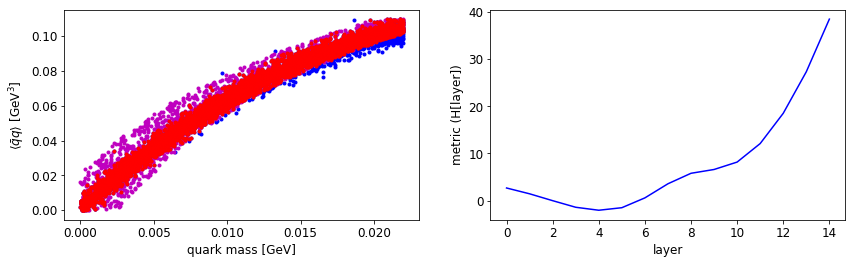

training epoch: 4900,   loss: 0.11556565016508102
lambda: 0.018041161820292473,   AdS radius: 3.2846059799194336[1/GeV]
[ 2.6786730e+00  1.4444056e+00 -1.1852026e-02 -1.4093794e+00
 -2.0405302e+00 -1.5016165e+00  5.8122182e-01  3.5745952e+00
  5.7973256e+00  6.6032910e+00  8.1750507e+00  1.2103628e+01
  1.8520613e+01  2.7329109e+01  3.8493011e+01]


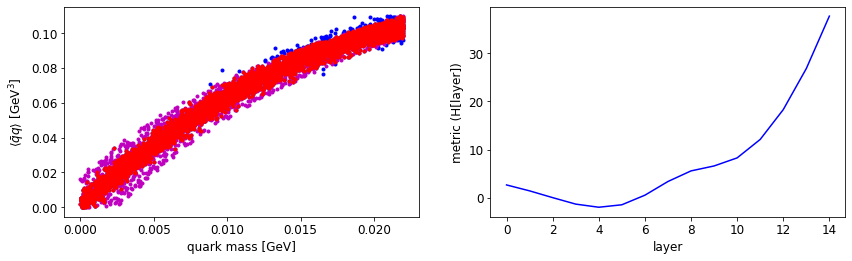

training epoch: 5000,   loss: 0.11193620413541794
lambda: 0.013238013722002506,   AdS radius: 3.4059789180755615[1/GeV]
[ 2.65462422e+00  1.42428625e+00  1.67090818e-02 -1.32790411e+00
 -1.97828424e+00 -1.46585584e+00  5.25267959e-01  3.36952472e+00
  5.57223129e+00  6.59818983e+00  8.27356625e+00  1.21052685e+01
  1.82963867e+01  2.68285694e+01  3.77237434e+01]


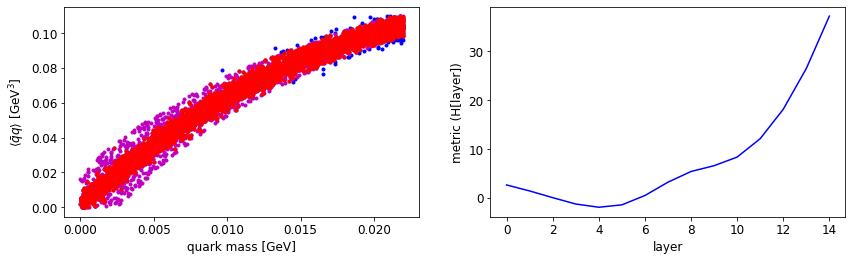

training epoch: 5100,   loss: 0.10985046625137329
lambda: 0.011900343932211399,   AdS radius: 3.4602339267730713[1/GeV]
[ 2.63924     1.4124805   0.0383159  -1.2661599  -1.92618    -1.4397886
  0.47345313  3.2017145   5.390116    6.5770583   8.340109   12.102437
 18.125895   26.467701   37.192146  ]


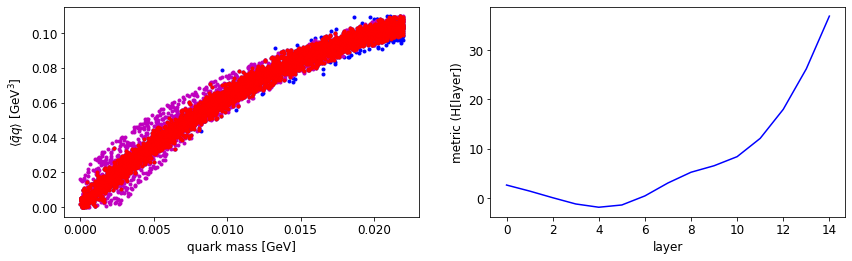

training epoch: 5200,   loss: 0.10644984990358353
lambda: 0.01078600250184536,   AdS radius: 3.5303378105163574[1/GeV]
[ 2.6291802   1.406189    0.05833901 -1.2124707  -1.8774078  -1.4175324
  0.42317274  3.0507164   5.227473    6.5474133   8.392023   12.1025
 17.995693   26.216587   36.922775  ]


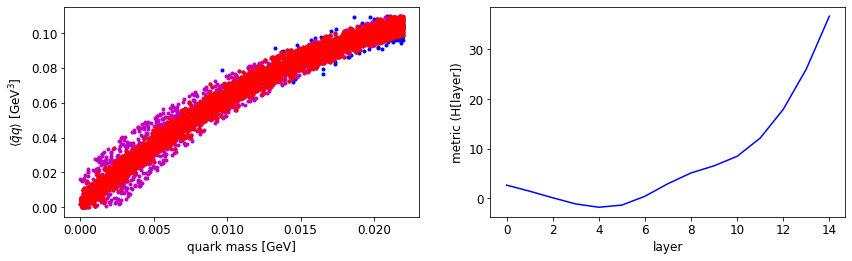

training epoch: 5300,   loss: 0.10438099503517151
lambda: 0.00902683474123478,   AdS radius: 3.569599151611328[1/GeV]
[ 2.6243382   1.4054413   0.07913594 -1.1630374  -1.829957   -1.3965834
  0.37596798  2.9142709   5.0806737   6.5121503   8.431252   12.100784
 17.884953   26.00636    36.669415  ]


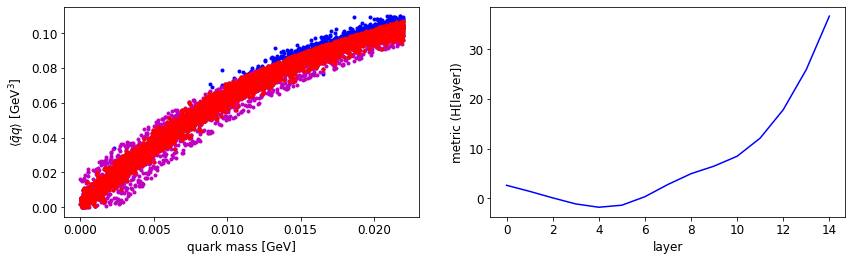

training epoch: 5400,   loss: 0.10265018790960312
lambda: 0.008565775118768215,   AdS radius: 3.623396396636963[1/GeV]
[ 2.6224225  1.4077502  0.0991319 -1.1190753 -1.7861761 -1.3781427
  0.3320155  2.7926247  4.9501247  6.4748015  8.461872  12.103758
 17.808794  25.882078  36.613518 ]


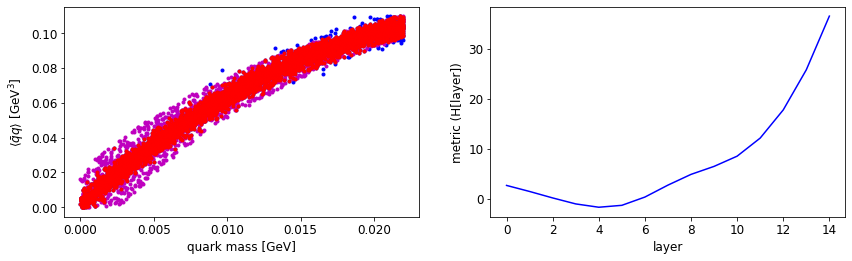

training epoch: 5500,   loss: 0.101776123046875
lambda: 0.008380289189517498,   AdS radius: 3.6088528633117676[1/GeV]
[ 2.6206508   1.4103562   0.11640955 -1.0818845  -1.7481661  -1.3636531
  0.29044217  2.6839783   4.8333826   6.4346356   8.480942   12.102657
 17.743856   25.77631    36.528294  ]


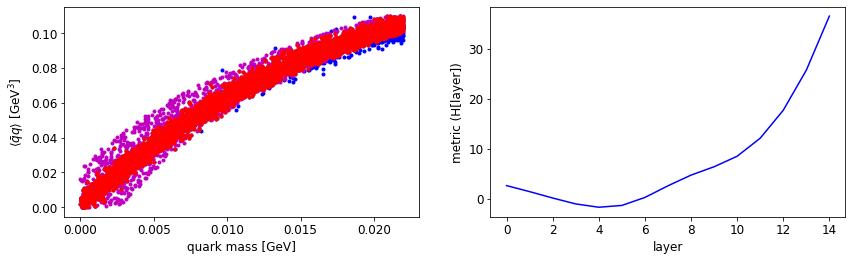

training epoch: 5600,   loss: 0.10101097077131271
lambda: 0.008505825884640217,   AdS radius: 3.623413562774658[1/GeV]
[ 2.619868    1.4141697   0.13363568 -1.0465287  -1.7114543  -1.3506497
  0.24838446  2.578312    4.719798    6.3910637   8.495025   12.1038685
 17.696695   25.715107   36.541943  ]


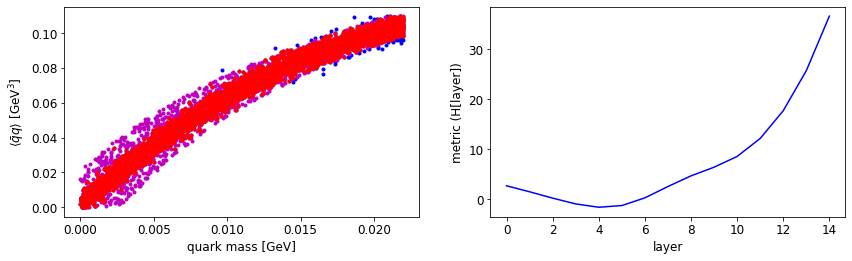

training epoch: 5700,   loss: 0.09930495172739029
lambda: 0.008001016452908516,   AdS radius: 3.635836124420166[1/GeV]
[ 2.6220257   1.4210944   0.15258652 -1.0115567  -1.6748723  -1.3370111
  0.20991482  2.4814372   4.6153846   6.3484073   8.50635    12.108824
 17.667103   25.691116   36.62664   ]


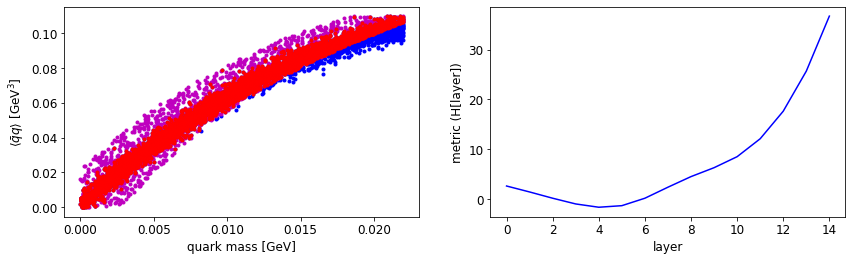

training epoch: 5800,   loss: 0.09900125861167908
lambda: 0.005637323949486017,   AdS radius: 3.6572189331054688[1/GeV]
[ 2.623949    1.4280142   0.17069438 -0.97883064 -1.6404806  -1.3254197
  0.1706662   2.3867004   4.5130987   6.302522    8.512492   12.113884
 17.648531   25.69269    36.740215  ]


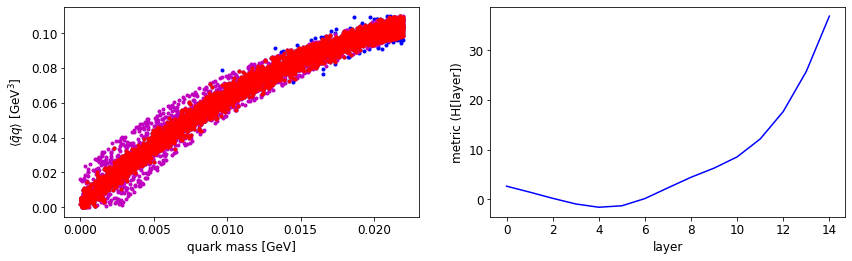

training epoch: 5900,   loss: 0.09791146218776703
lambda: 0.007821064442396164,   AdS radius: 3.6458308696746826[1/GeV]
[ 2.627361    1.4364839   0.18923713 -0.94749147 -1.6076057  -1.3140715
  0.13479964  2.300426    4.419375    6.2577806   8.5149555  12.118499
 17.636328   25.69811    36.81955   ]


In [27]:
total_epoch=6000
show_epoch_each=100

for epoch in range(total_epoch):
    if epoch==0:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==3000:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==4500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [31]:
for i in range(1, N_layer):
    regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)

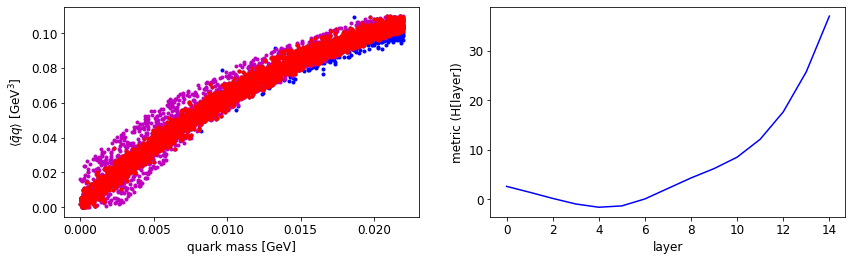

training epoch: 0,   loss: 0.0967862606048584
lambda: 0.007135370746254921,   AdS radius: 3.6714813709259033[1/GeV]
[ 2.6303852   1.4447458   0.20715949 -0.9176267  -1.5763891  -1.3046043
  0.09735749  2.2138522   4.325148    6.2094455   8.513098   12.123139
 17.632608   25.72362    36.93398   ]


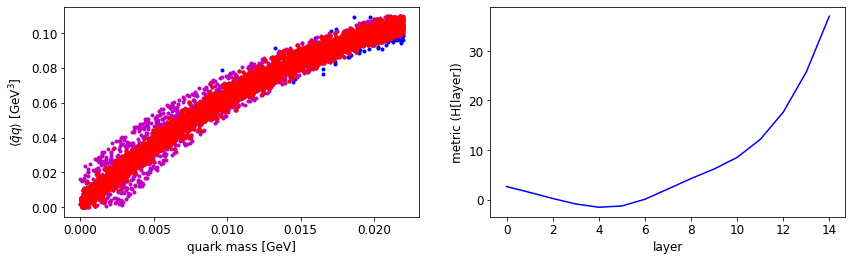

training epoch: 100,   loss: 0.09613266587257385
lambda: 0.006766446866095066,   AdS radius: 3.6756465435028076[1/GeV]
[ 2.6352704   1.4548507   0.2260405  -0.88826215 -1.5459746  -1.2946115
  0.06391199  2.1356192   4.239401    6.1635604   8.509235   12.127787
 17.632824   25.748123   37.01952   ]


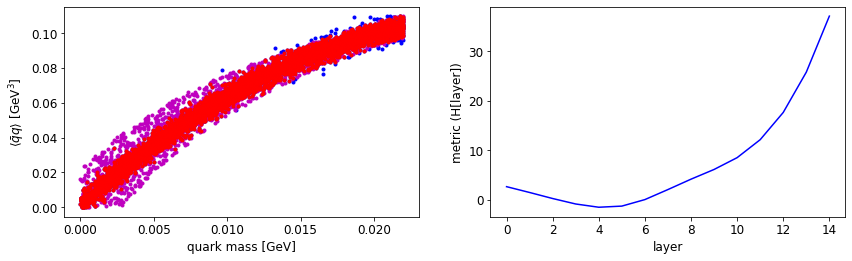

training epoch: 200,   loss: 0.09433522820472717
lambda: 0.00778497289866209,   AdS radius: 3.685434103012085[1/GeV]
[ 2.63941050e+00  1.46435857e+00  2.44009346e-01 -8.60548496e-01
 -1.51749158e+00 -1.28643584e+00  2.94806026e-02  2.05786514e+00
  4.15381527e+00  6.11491060e+00  8.50119781e+00  1.21306505e+01
  1.76356068e+01  2.57761402e+01  3.70950661e+01]


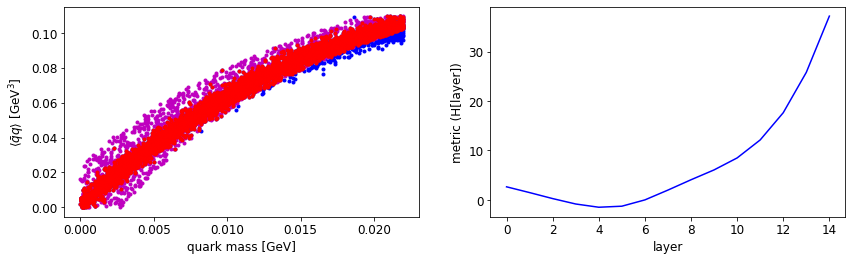

training epoch: 300,   loss: 0.0956789180636406
lambda: 0.006460091564804316,   AdS radius: 3.6841349601745605[1/GeV]
[ 2.6440904e+00  1.4744960e+00  2.6214364e-01 -8.3355850e-01
 -1.4900324e+00 -1.2785395e+00 -3.1872743e-03  1.9844230e+00
  4.0725899e+00  6.0669580e+00  8.4913607e+00  1.2133849e+01
  1.7643175e+01  2.5811737e+01  3.7195976e+01]


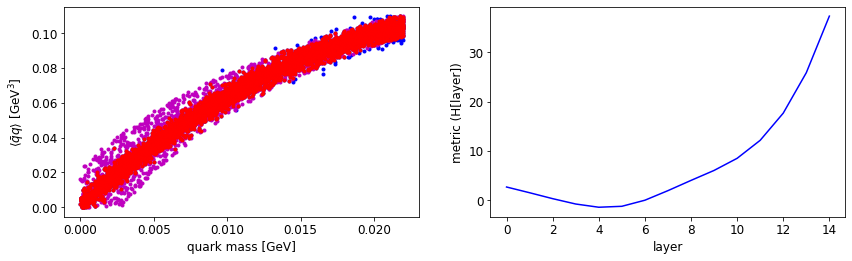

training epoch: 400,   loss: 0.09281833469867706
lambda: 0.007268733344972134,   AdS radius: 3.704620361328125[1/GeV]
[ 2.6494477e+00  1.4855082e+00  2.8103256e-01 -8.0627924e-01
 -1.4625669e+00 -1.2707075e+00 -3.5519678e-02  1.9121561e+00
  3.9923499e+00  6.0184383e+00  8.4809313e+00  1.2140636e+01
  1.7663086e+01  2.5878885e+01  3.7379681e+01]


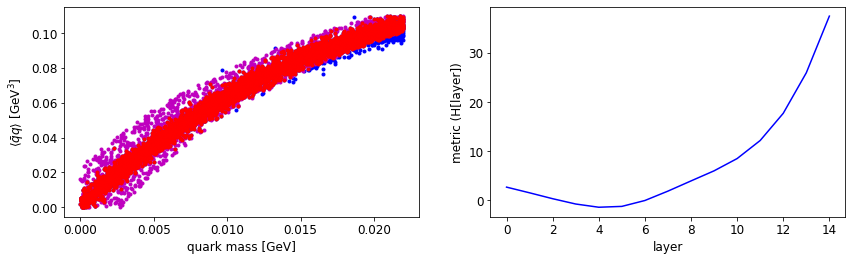

training epoch: 500,   loss: 0.09290379285812378
lambda: 0.006376251578330994,   AdS radius: 3.6911158561706543[1/GeV]
[ 2.6549866   1.4965168   0.2993057  -0.7805945  -1.4370286  -1.2634832
 -0.06536175  1.8457018   3.91793     5.971351    8.46763    12.143136
 17.67539    25.917315   37.44944   ]


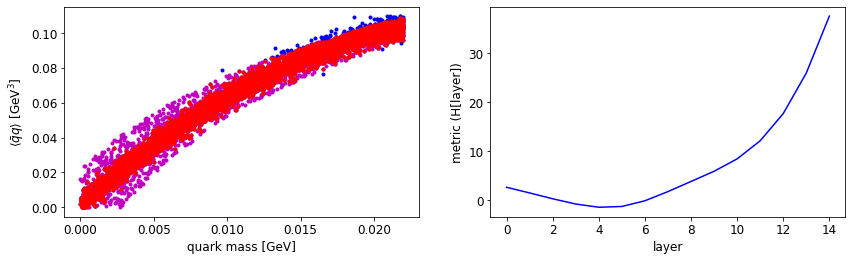

training epoch: 600,   loss: 0.09161088615655899
lambda: 0.007637974340468645,   AdS radius: 3.702101230621338[1/GeV]
[ 2.6605742   1.507463    0.31710672 -0.7560484  -1.412898   -1.2569312
 -0.0939445   1.7826694   3.8471007   5.9254484   8.453913   12.147352
 17.694946   25.974709   37.579876  ]


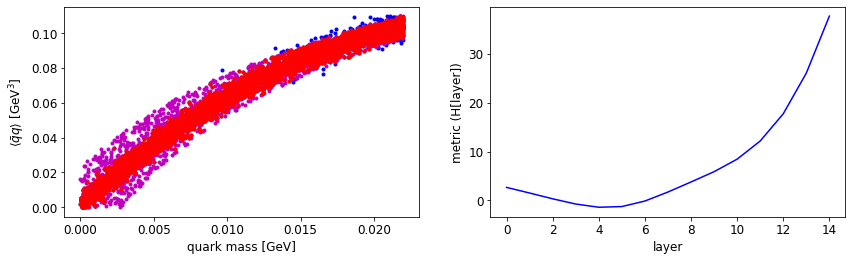

training epoch: 700,   loss: 0.09073042869567871
lambda: 0.007621121127158403,   AdS radius: 3.698519468307495[1/GeV]
[ 2.665782    1.5180181   0.33423957 -0.73269886 -1.390214   -1.2511874
 -0.12170242  1.722211    3.7788217   5.8797884   8.43853    12.15025
 17.713968   26.02821    37.688656  ]


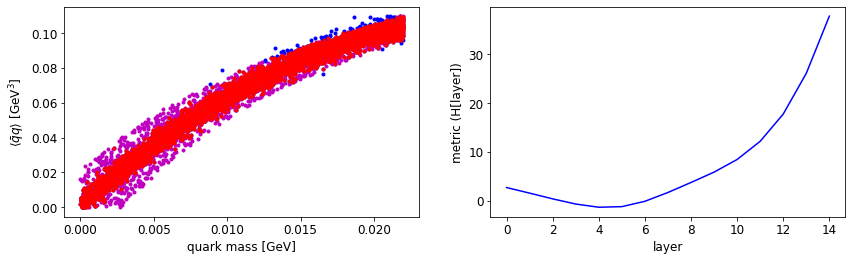

training epoch: 800,   loss: 0.09066696465015411
lambda: 0.006826491095125675,   AdS radius: 3.703143358230591[1/GeV]
[ 2.6724799   1.530289    0.3531447  -0.70776516 -1.366227   -1.2444305
 -0.14867042  1.6624678   3.710876    5.8336706   8.422826   12.154783
 17.738245   26.09189    37.81568   ]


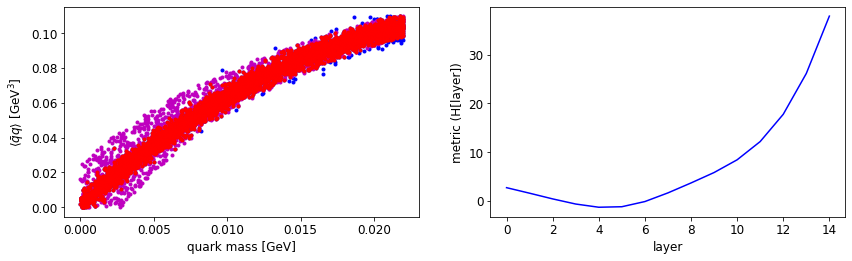

training epoch: 900,   loss: 0.0917179211974144
lambda: 0.007623790763318539,   AdS radius: 3.69003963470459[1/GeV]
[ 2.6769047   1.5400549   0.3690903  -0.6864213  -1.3459859  -1.2402041
 -0.17547935  1.6055983   3.646113    5.788088    8.405029   12.156948
 17.760695   26.152264   37.942665  ]


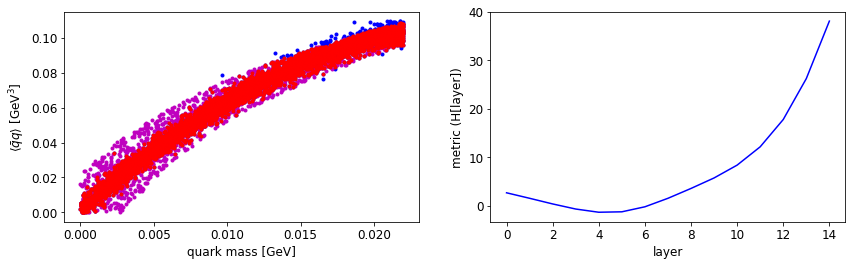

training epoch: 1000,   loss: 0.08977454900741577
lambda: 0.007465831004083157,   AdS radius: 3.707645893096924[1/GeV]
[ 2.6835      1.5521172   0.3873549  -0.6629261  -1.3238925  -1.2344704
 -0.20108826  1.5497026   3.5819156   5.742479    8.387234   12.160704
 17.787367   26.2195     38.066124  ]


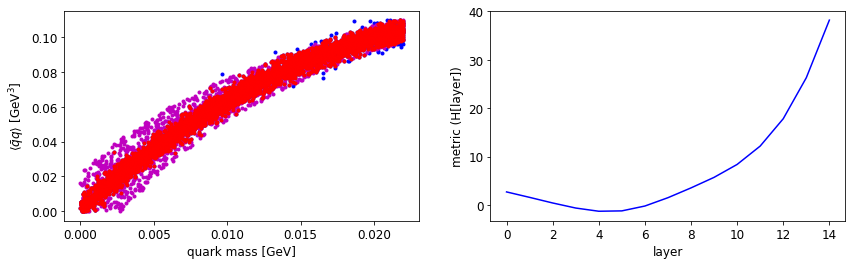

training epoch: 1100,   loss: 0.08871554583311081
lambda: 0.00681861350312829,   AdS radius: 3.6966464519500732[1/GeV]
[ 2.6894324   1.563359    0.40443164 -0.6411064  -1.3035533  -1.2293631
 -0.22492379  1.4979577   3.5222187   5.6992683   8.3696575  12.164421
 17.814344   26.286596   38.19344   ]


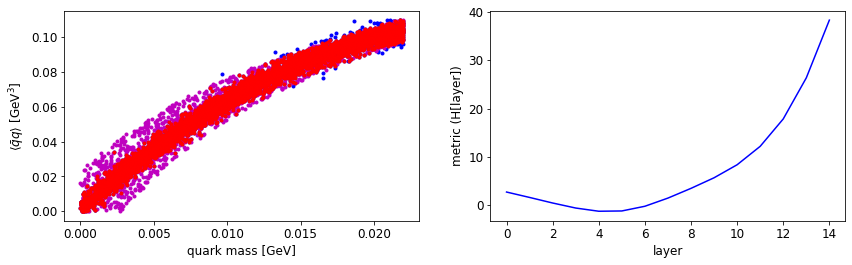

training epoch: 1200,   loss: 0.08816425502300262
lambda: 0.006658486556261778,   AdS radius: 3.7372894287109375[1/GeV]
[ 2.695362    1.5747522   0.42172793 -0.61918116 -1.2834471  -1.225065
 -0.2503302   1.4439473   3.4597116   5.6528964   8.349288   12.166881
 17.842293   26.355602   38.31827   ]


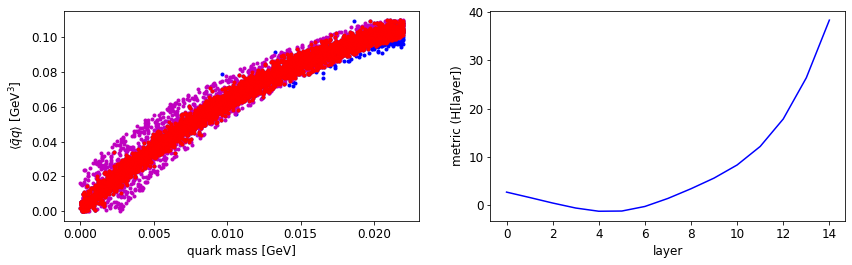

training epoch: 1300,   loss: 0.08948070555925369
lambda: 0.005654746666550636,   AdS radius: 3.726155996322632[1/GeV]
[ 2.70166     1.5863904   0.4389261  -0.5977909  -1.2639251  -1.2202607
 -0.27294853  1.394873    3.4023137   5.6093864   8.328884   12.166487
 17.86163    26.396286   38.35577   ]


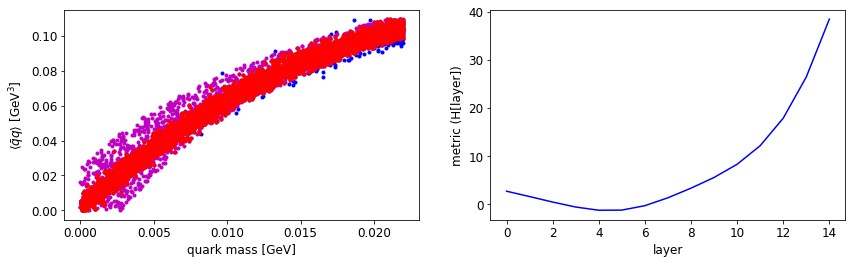

training epoch: 1400,   loss: 0.08752532303333282
lambda: 0.006935995537787676,   AdS radius: 3.717527389526367[1/GeV]
[ 2.7067327   1.5968045   0.45486066 -0.57783103 -1.2459507  -1.2167684
 -0.29622462  1.3458099   3.3449633   5.565277    8.307724   12.167041
 17.88601    26.454964   38.468075  ]


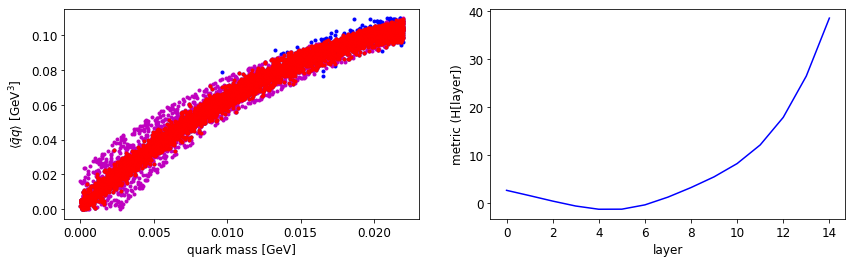

training epoch: 1500,   loss: 0.0867285430431366
lambda: 0.006871578749269247,   AdS radius: 3.718780994415283[1/GeV]
[ 2.7134757  1.6088203  0.4722513 -0.5566367 -1.226857  -1.2118212
 -0.317181   1.2998934  3.2907686  5.5234413  8.288115  12.16934
 17.913176  26.518702  38.588783 ]


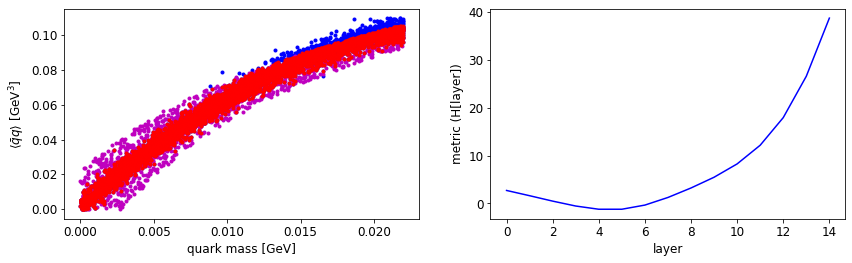

training epoch: 1600,   loss: 0.0873984843492508
lambda: 0.007591902744024992,   AdS radius: 3.7360119819641113[1/GeV]
[ 2.7194612   1.6200004   0.48871207 -0.5365427  -1.2089949  -1.207855
 -0.338497    1.2542281   3.2368433   5.4812593   8.267849   12.171976
 17.943655   26.59379    38.745583  ]


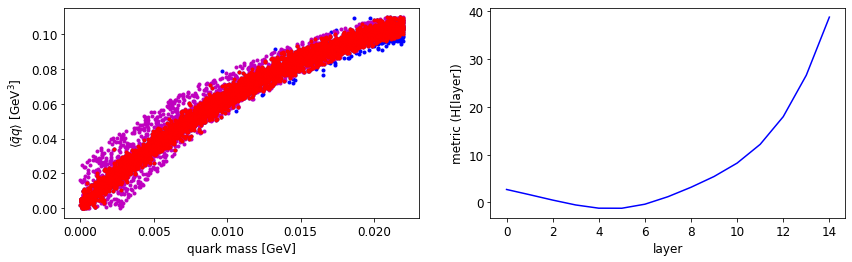

training epoch: 1700,   loss: 0.085710309445858
lambda: 0.006480742245912552,   AdS radius: 3.7095088958740234[1/GeV]
[ 2.724678    1.6301802   0.5038379  -0.5181096  -1.1927354  -1.2045016
 -0.35844663  1.2117579   3.1863215   5.4407716   8.2467     12.170792
 17.964144   26.639431   38.798893  ]


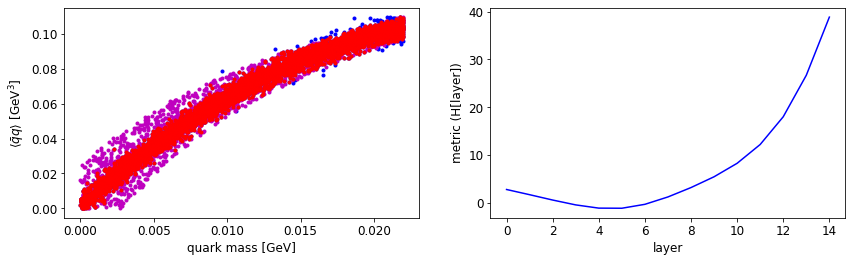

training epoch: 1800,   loss: 0.08518014848232269
lambda: 0.0074297101236879826,   AdS radius: 3.6921074390411377[1/GeV]
[ 2.7304378   1.6409084   0.5194527  -0.49931055 -1.1761997  -1.2006953
 -0.37748632  1.1706265   3.1371193   5.401087    8.226083   12.170633
 17.987175   26.691774   38.883247  ]


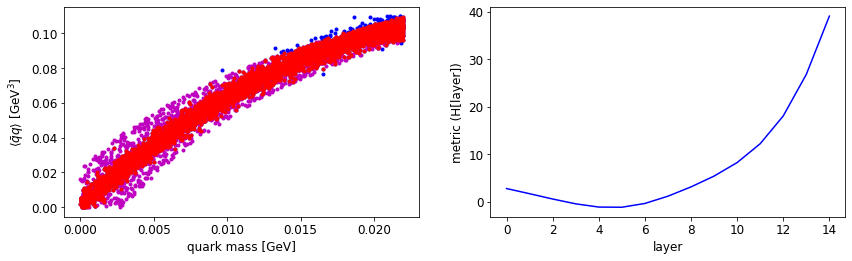

training epoch: 1900,   loss: 0.08602715283632278
lambda: 0.006982422433793545,   AdS radius: 3.696723222732544[1/GeV]
[ 2.7368755   1.6524785   0.5360393  -0.47952834 -1.1588501  -1.196415
 -0.3965016   1.1290969   3.0872526   5.36085     8.205799   12.173232
 18.018387   26.766739   39.03096   ]


In [33]:
total_epoch=2000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
print(c_reg1)

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)